# Tripsacum seedhead tutorial (For Google Colaboratory)


### About this jupyter notebook

This notebook contains the code for getting the following phenotypes from tripsacum seed head images.
- length of entire seed head
- length of female flower part
- length of male flower part
- color phenotypes of each part
- estimate of seed count 

Project context: This is a New Roots for Restoration project that is being run both at Kansas University (KU) Field Research Site and the Danforth Field Research Site. All seed heads were removed and imaged once they were determined to be mature, and the imaging happened with cell phones. In the KU branch of the experiment, seed heads were imaged in a growth chamber (for better and more consistent lighting conditions compared to in the field) and there are usually 3 seed heads per image. Seed heads within a single image all come from the same plant.

Made by Haley Schuhl. Updated May 2025. 

In [ ]:
# Install PlantCV and required dependencies
%pip install "altair>=5" ipympl plantcv

# Give access and mount your Google Drive (need a Google Account)
# Change path to directory you wish output files to be saved to.
from google.colab import drive
drive.mount('/content/gdrive')

# Enable widget feature with matplotlib
from google.colab import output
output.enable_custom_widget_manager()

#View working directory, may need to change path
%pwd

# Importing libraries and image

In [1]:
## Import software libraries
%matplotlib widget
import matplotlib
import numpy as np
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__


'4.8.dev110+gb56a9b06'

## Input/Output variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later. Remember, always keep your raw images separate from your newly processed images!

In [2]:
# Input/output options
args = WorkflowInputs(
    images=["./img/16052025_kansas_01.jpg"],
    names="image1",
    result="out_data.json",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

# Set debug to the global parameter 
pcv.params.debug = args.debug
# Quite warnings
pcv.params.verbose = False
# Global settings
matplotlib.rcParams["figure.max_open_warning"] = False

## Read in image data

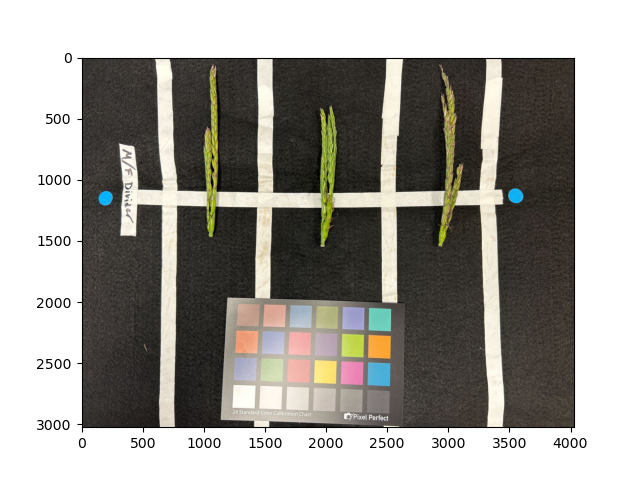

In [3]:
img = pcv.io.open_url(url="https://raw.githubusercontent.com/danforthcenter/plantcv-tutorial-tripsacum-seedhead/main/img/16052025_kansas_01.jpg")

# Standardize colorspace (correct color) 

Corrects the color of the input image based on the target color matrix using an affine transformation in the RGB space after automatic detection of a color card within the image.

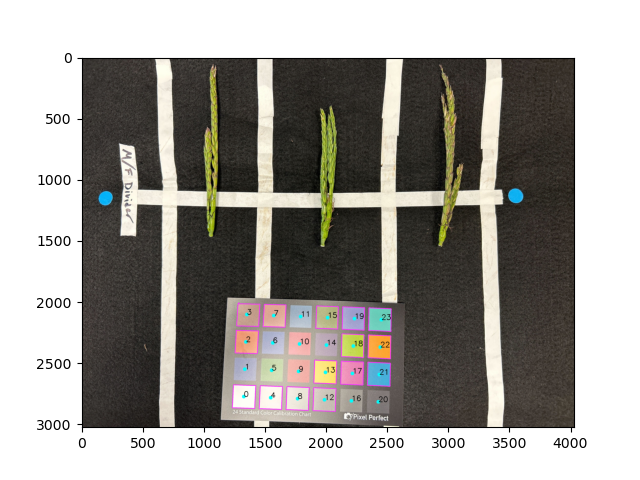

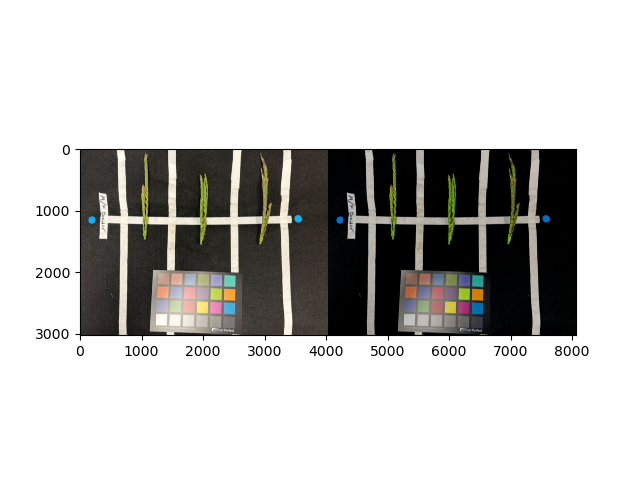

In [4]:
pcv.params.text_size = 2
pcv.params.text_thickness = 4
# Perform color correction 
img = pcv.transform.auto_correct_color(rgb_img=img, radius=15)

## Visualize colorspaces 

The visualization tool converts the color image into HSV, LAB, and CMYK colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

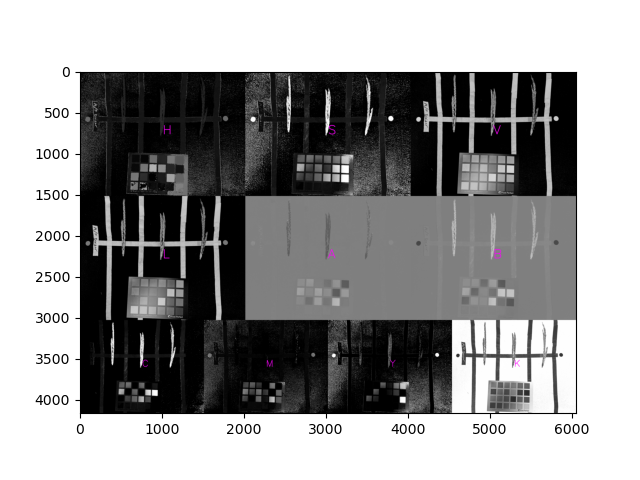

In [5]:
## Visualize all possible colorspaces
pcv.params.text_size = 10
pcv.params.text_thickness = 15
vis = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

## Convert the color image to grayscale
Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.


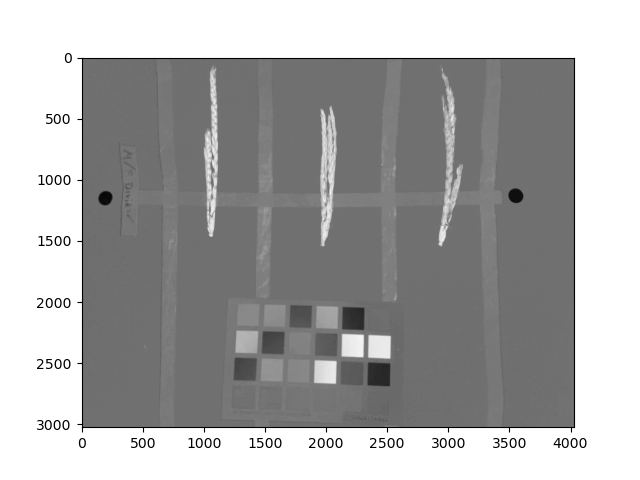

In [6]:
gray = pcv.rgb2gray_lab(rgb_img=img, channel="b")

## Threshold the grayscale image 
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Because the seed-heads are the lighter pixels in this image, use object_type="light" to do a traditional threshold.

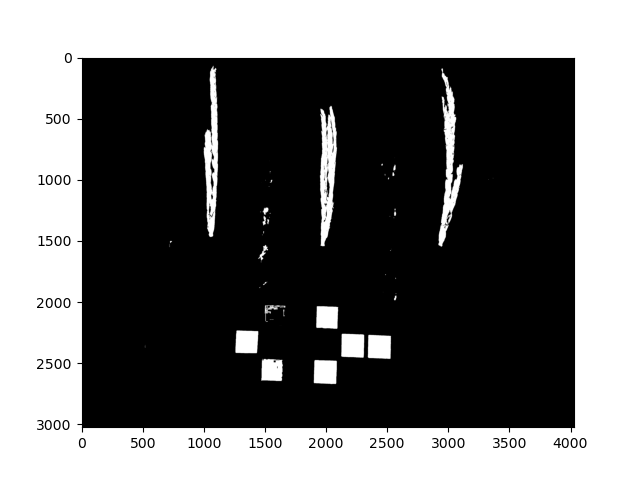

In [7]:
## Roughly segment the whole flower from the background 
total_flower = pcv.threshold.binary(gray_img=gray, threshold=145, object_type="light")

## Remove small background noise
Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size.



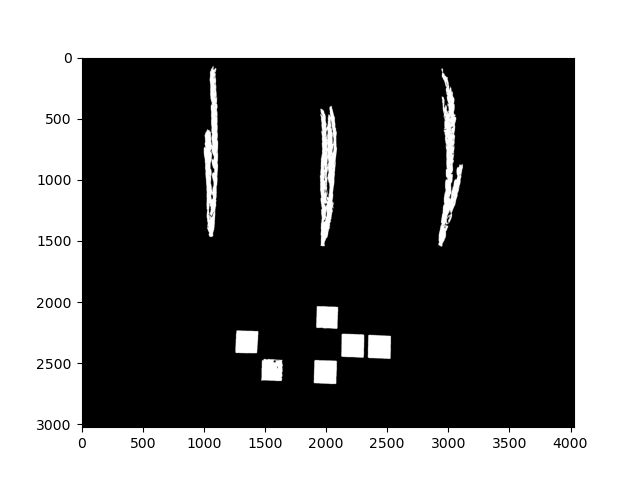

In [8]:
## Fill small objects to clean up the mask
total_flower_filled = pcv.fill(total_flower, size=3500)

## Define the region of interest (ROI) to separate seed heads. 
Each ROI will be associated with a seed head later. The ROIs do not need to completely contain a whole inflorescence but must only overlap one each. 

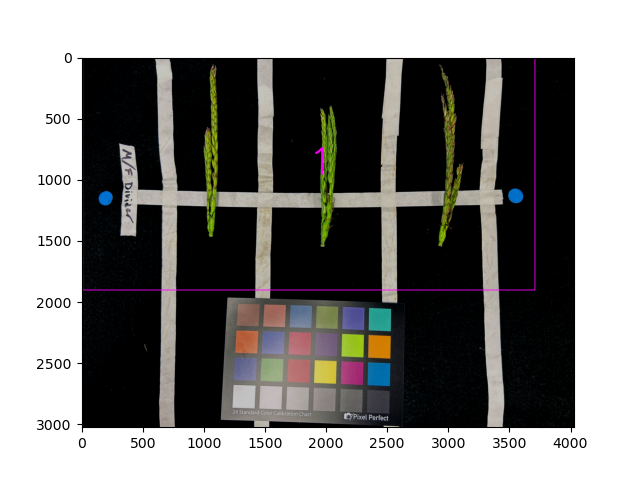

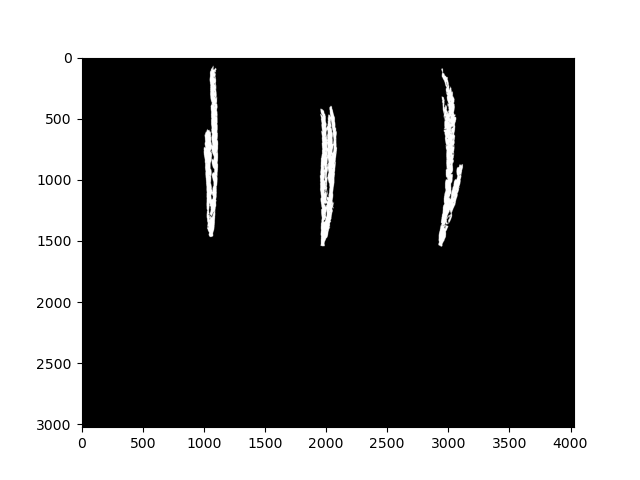

In [9]:
### First use a single ROI to clean the object mask. This will speed up downstream steps 
## Define a region of interest to remove the color card
roi = pcv.roi.rectangle(img=img, x=5, y=5, h=1900, w=3700) 
total_flower_clean = pcv.roi.filter(roi=roi, mask=total_flower_filled, roi_type="partial")


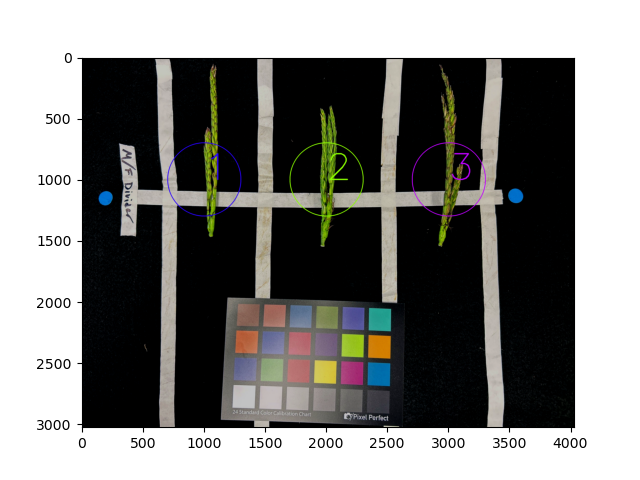

In [10]:
## Make 3 ROIs to separate seed heads (even if mask is broken up into multiple peices) 
pcv.params.text_size = 10
pcv.params.text_thickness = 10

# Create multi-ROI 
roi_objects = pcv.roi.multi(img=img, coord=[(1000,1000), (2000, 1000), (3000,1000)], radius=300, spacing=None, nrows=None, ncols=None)


## Create a labeled mask
In order to measure each plant separately, rather than as one object of disconnected blobs, we must create a labeled masked where each plant has a specific pixel value even in the case of disconnected leaves in the binary mask.

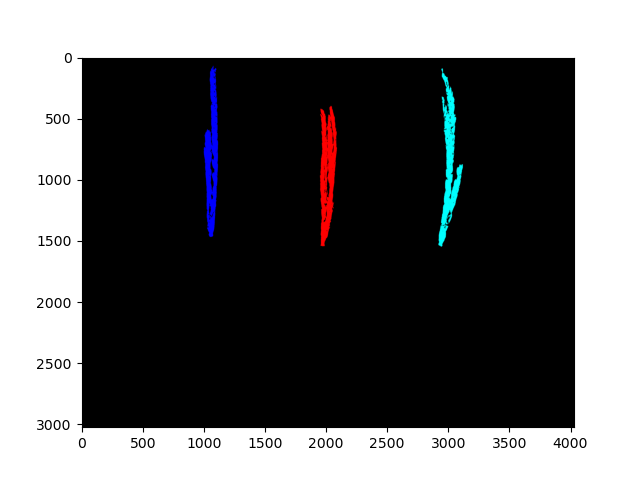

In [11]:
total_label, num_t = pcv.create_labels(mask=total_flower_clean, rois=roi_objects, roi_type="partial")

## Measure each seed-head (total)
Analyze shape and size perameters of each seed-head. Traits are automatically saved to `Outputs`.


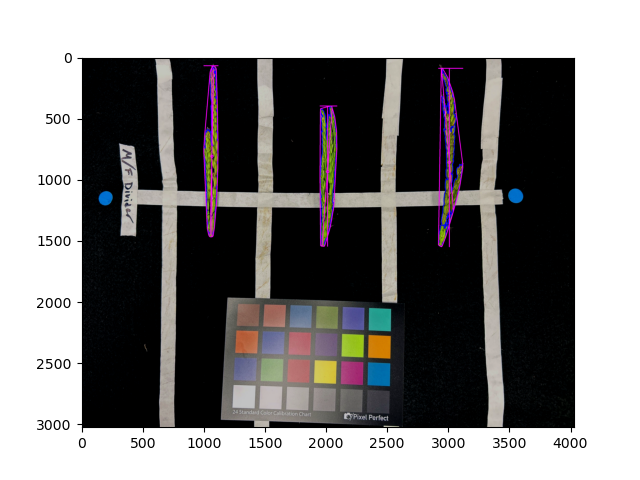

In [12]:
_ = pcv.analyze.size(img=img, labeled_mask=total_label, n_labels=num_t, label="total")


# Detect circles to define boundary line
Separate out the male vs female part of the flower. This is done by detecting the boundary line with the use of stickers that are blue/purple. 


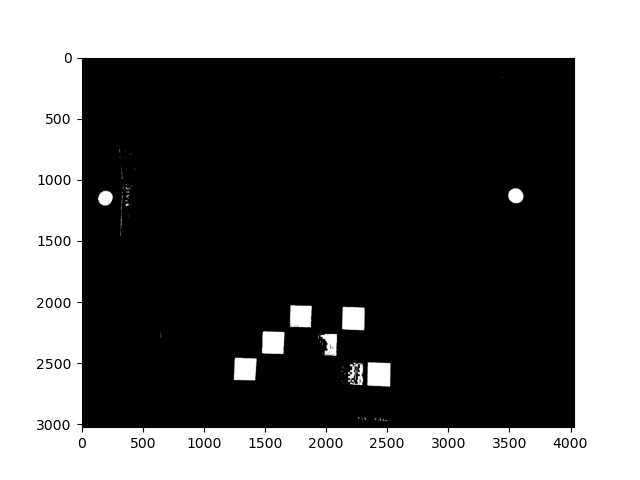

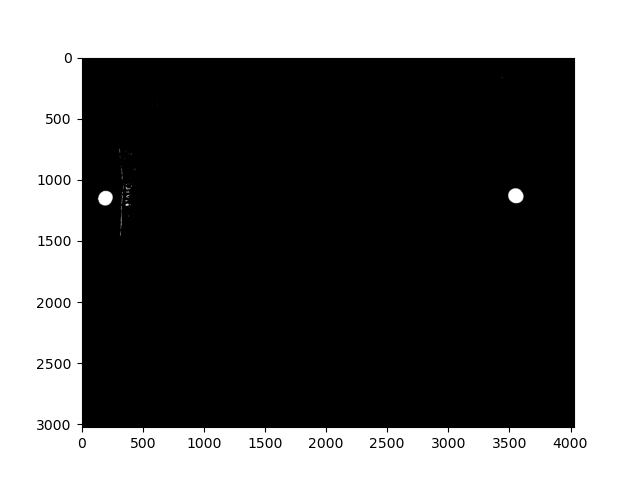

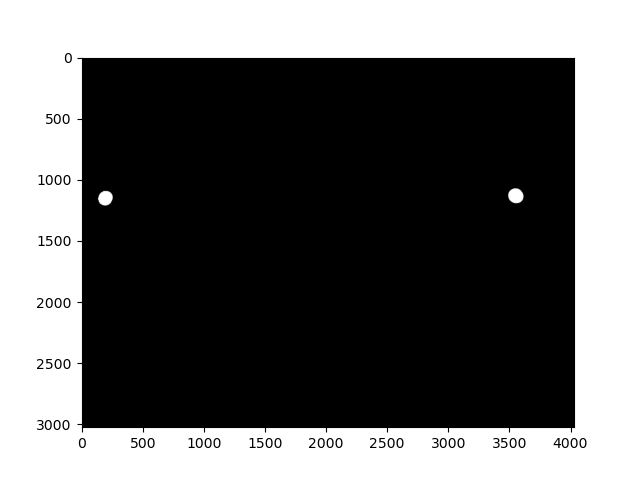

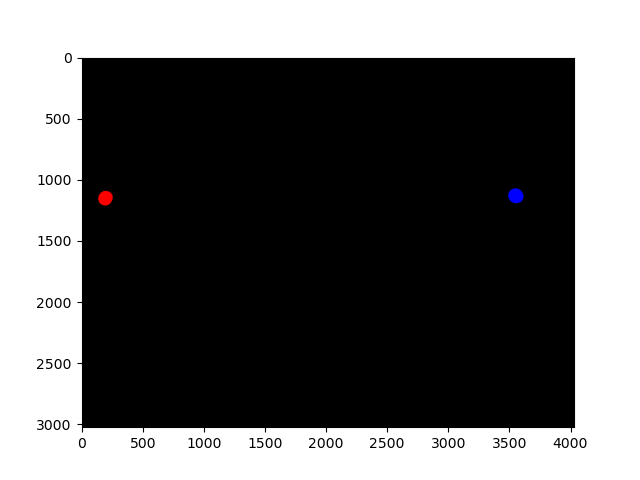

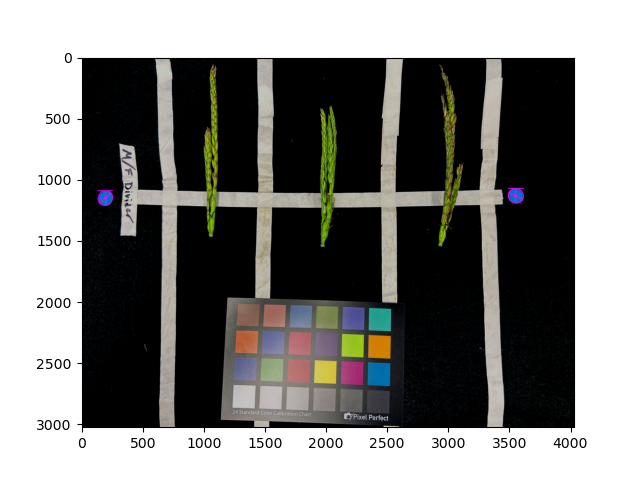

In [13]:
# Circles are darker than the background in the "b" channel so do a "dark" binary threshold 
circle_mask = pcv.threshold.binary(gray_img=gray, threshold=115, object_type="dark")
# Use ROI to remove color card chips from the circle mask
circle_mask = pcv.roi.filter(roi=roi, mask=circle_mask, roi_type="partial")
# Measure the circles 
clean_circle_mask = pcv.fill(circle_mask, size=1000)
circle_labels, num = pcv.create_labels(mask=clean_circle_mask)
_ = pcv.analyze.size(img=img, labeled_mask=circle_labels, n_labels=num, label="sticker")

# Set the line position based on circle location 
## Average the y-coordinate of the center of the circles 
line_pos = (pcv.outputs.observations['sticker_1']['center_of_mass']['value'][1] + 
                 pcv.outputs.observations['sticker_1']['center_of_mass']['value'][1]) / 2.
    


## Use line position to separate flower parts 

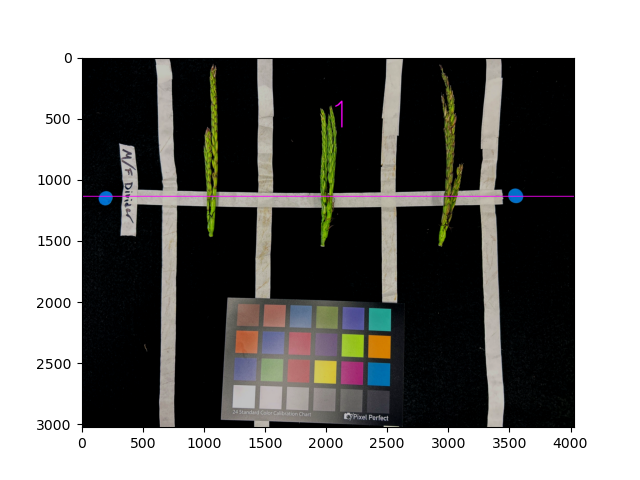

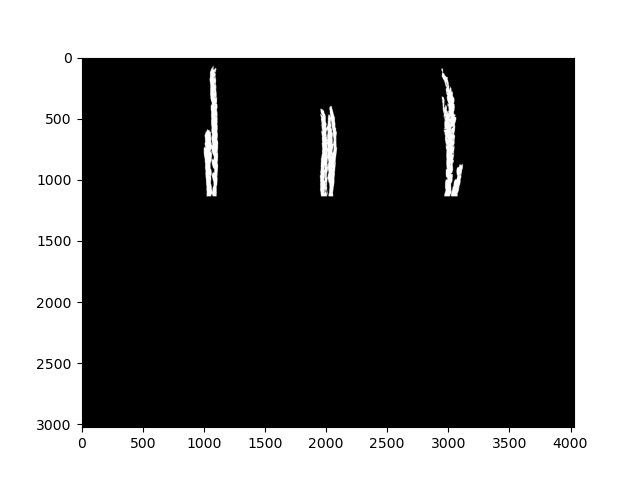

In [14]:
roi1 = pcv.roi.rectangle(img=img, x=0, y=5, h=line_pos, w=np.shape(img)[1])
male_flower_mask = pcv.roi.filter(roi=roi1, mask=total_flower_clean, roi_type="cutto")


## Create a labeled male flower mask 

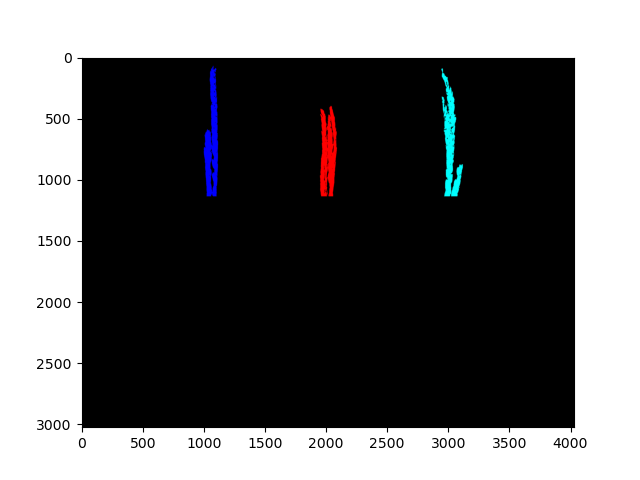

In [15]:
male_label, num_m = pcv.create_labels(mask=male_flower_mask, rois=roi_objects, roi_type="partial")

## Analyze size and color of male flower part 

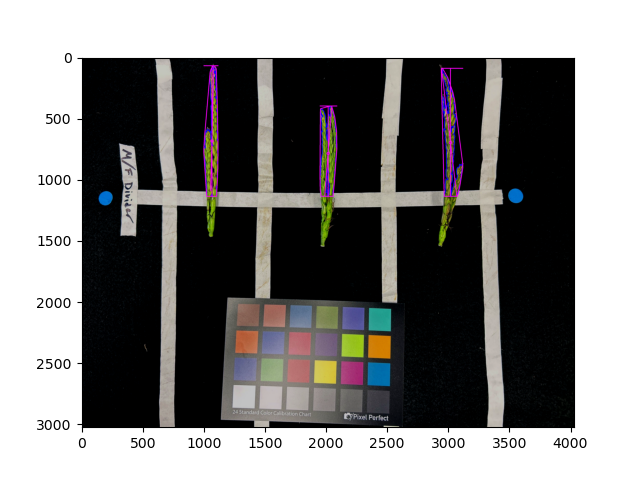

alt.FacetChart(...)

In [16]:
shape_img = pcv.analyze.size(img=img, labeled_mask=male_label, n_labels=num_m, label="male")
color_hist = pcv.analyze.color(rgb_img=img, labeled_mask=male_label, n_labels=num_m, label="male")

## Subtract to get female flower mask 
Analyze shape and size perameters of the female flower part. Note the `label` is updated so the three instances of size measurements are distinguishable from the whole seed head size data. 


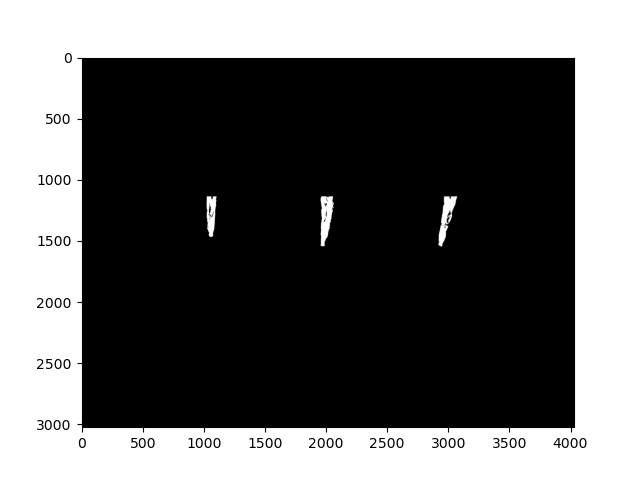

In [17]:
female_flower = pcv.image_subtract(total_flower_clean, male_flower_mask)                 

## Create a labeled female flower mask 

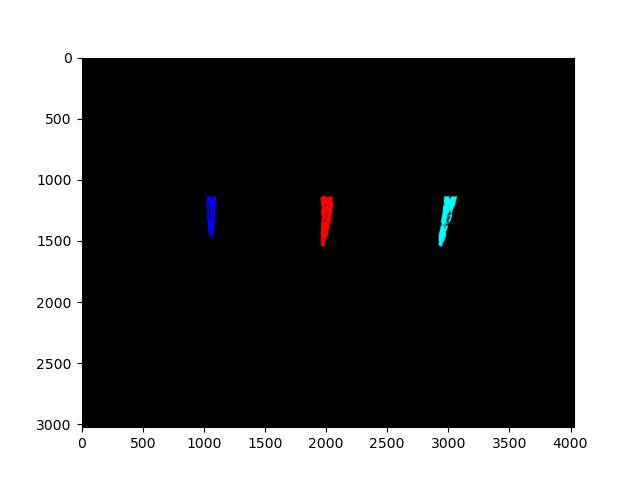

In [18]:
female_label, num_f = pcv.create_labels(mask=female_flower, rois=roi_objects, roi_type="partial")

## Analyze female flower parts 

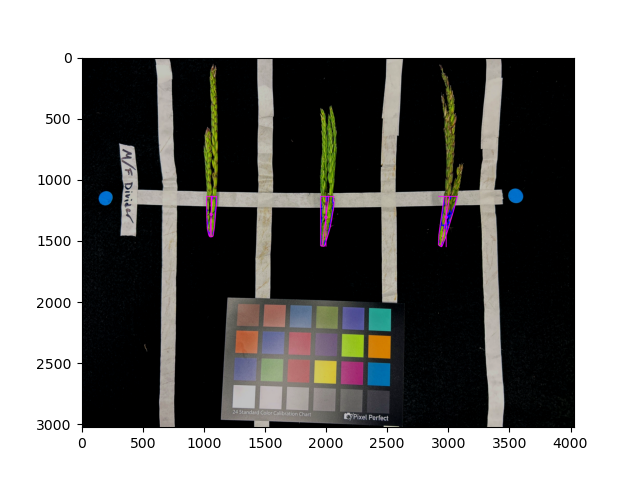

alt.FacetChart(...)

In [19]:
shape_img = pcv.analyze.size(img=img, labeled_mask=female_label, n_labels=num_f, label="female")
color_hist = pcv.analyze.color(rgb_img=img, labeled_mask=female_label, n_labels=num_f, label="female")

# Estimate seed number 

In this case, the number of objects reported from the analyze watershed function is a rough estimation of the number of seeds. The Watershed Segmentation Function is a PlantCV function based on code contributed by Suxing Liu, Arkansas State University for use counting arabidopsis leaves. For more information see https://github.com/lsx1980/Leaf_count.

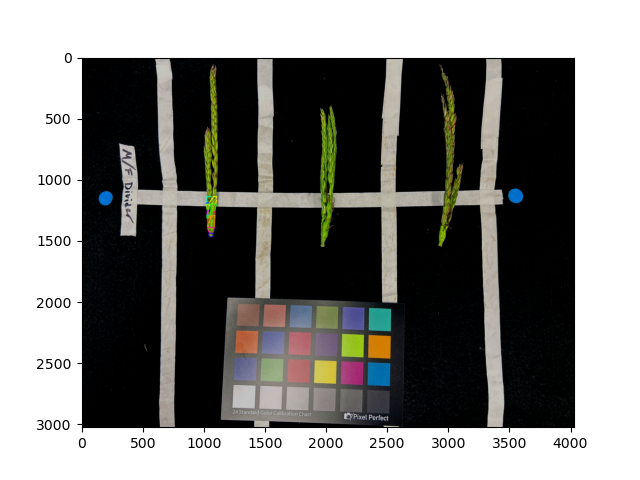

13


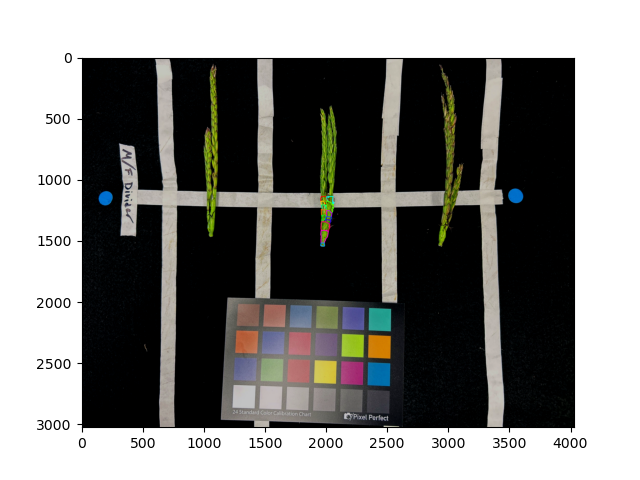

14


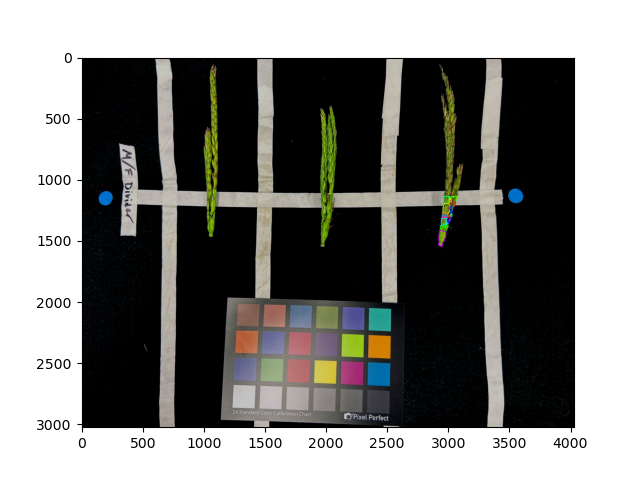

16


In [20]:
# Custom code for printing seed count PER seed-head 

mask_copy = np.copy(female_label)
for i in [1,2,3]:
    ## Subset the mask to get one seed-head per mask 
    submask = np.where(mask_copy == i, 255, 0).astype(np.uint8)
    labels = pcv.watershed_segmentation(rgb_img=img, mask=submask, distance=10, label=None)
    print(len(np.unique(labels)))
    # Save observations to outputs per seed-head
    pcv.outputs.add_observation(sample="female_" + str(i),
                            variable='estimated_seed_count_per_head',
                            trait='watershed seed count',
                            method='plantcv.watershed_segmentation',
                            scale='none', datatype=int,
                            value=len(np.unique(labels)), label="none")


# Save results
During analysis, measurements are stored in the background in the `Outputs` recorder.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using size analysis. Color analysis saves frequency data about pixel values in each of the specified colorspace channels and 'hue_circular_mean', 'hue_circular_std', and 'hue_median'. 

Here, results are saved to JSON file, and this allows for database concatenation while running workflows in parallel.

In [21]:
## Save data out to file 

pcv.outputs.save_results(filename=args.result, outformat="json")

#### Save data as CSV format 
#### Note: this format will be removed in version 5
Conversion to CSV happens automatically after parallel processsing in PlantCV v4.8 and newer. 


In [22]:
## Save data out to file 
pcv.outputs.save_results(filename="out_data.csv", outformat="csv")